In [1]:
# importing libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [2]:
#read the file
df = pd.read_csv('NSE-TATAGLOBAL.csv')

#print the head
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


<Figure size 576x432 with 0 Axes>

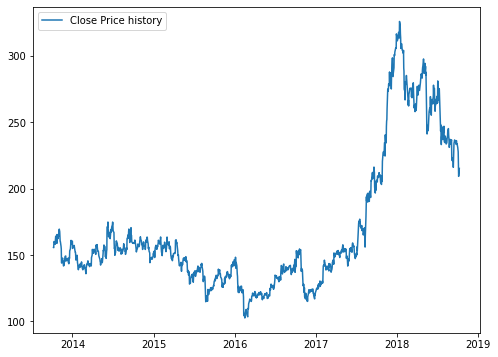

In [3]:
#setting index as date
plt.figure(figsize=(8,6))
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(8,6))
plt.plot(df['Close'], label='Close Price history')
plt.legend();

In [4]:
print('Shape of the data:',df.shape)

# setting the index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

# NOTE: While splitting the data into train and validation set, we cannot use random splitting since that will destroy the time component. So here we have set the last year’s data into validation and the 4 years’ data before that into train set.

# splitting into train and validation
train = new_data[:987]
valid = new_data[987:]
new_data =new_data.set_index("Date")

Shape of the data: (1235, 8)


In [5]:
ploty = valid.copy()
trainy = train.copy()
ploty = ploty.set_index("Date")
testy = ploty.copy()
trainy = trainy.set_index("Date")

In [6]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPool1D


In [7]:

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [8]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=50)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
ploty['CNN'] = closing_price

Epoch 1/50
29/29 [==============================] - 6s 47ms/step - loss: 0.0071
Epoch 2/50
29/29 [==============================] - 1s 46ms/step - loss: 0.0012
Epoch 3/50
29/29 [==============================] - 1s 44ms/step - loss: 8.3877e-04
Epoch 4/50
29/29 [==============================] - 1s 44ms/step - loss: 7.6453e-04
Epoch 5/50
29/29 [==============================] - 1s 44ms/step - loss: 7.7035e-04
Epoch 6/50
29/29 [==============================] - 1s 44ms/step - loss: 7.3958e-04
Epoch 7/50
29/29 [==============================] - 1s 45ms/step - loss: 7.3571e-04
Epoch 8/50
29/29 [==============================] - 1s 46ms/step - loss: 6.8044e-04
Epoch 9/50
29/29 [==============================] - 1s 49ms/step - loss: 6.4524e-04
Epoch 10/50
29/29 [==============================] - 1s 47ms/step - loss: 6.1540e-04
Epoch 11/50
29/29 [==============================] - 1s 46ms/step - loss: 5.7205e-04
Epoch 12/50
29/29 [==============================] - 1s 46ms/step - loss: 5.5688e-

In [9]:

# create and fit the CNN network
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D,Flatten
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


model.fit(x_train, y_train, epochs=100)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
ploty['LSTM'] = closing_price

Epoch 1/100
29/29 [==============================] - 1s 5ms/step - loss: 0.0076
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 7.3556e-04
Epoch 4/100
29/29 [==============================] - 0s 5ms/step - loss: 6.6201e-04
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 5.6964e-04
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 4.7760e-04
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 4.5013e-04
Epoch 8/100
29/29 [==============================] - 0s 4ms/step - loss: 4.6164e-04
Epoch 9/100
29/29 [==============================] - 0s 4ms/step - loss: 4.3161e-04
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 4.9488e-04
Epoch 11/100
29/29 [==============================] - 0s 4ms/step - loss: 4.0947e-04
Epoch 12/100
29/29 [==============================] - 0s 5ms/step - loss: 4.4386e-

In [10]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [11]:
### Testing For Stationarity
df = new_data.copy()
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Close'])


In [12]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [13]:
adfuller_test(df['Close'])

ADF Test Statistic : -0.9548956355710587
p-value : 0.7693577507390474
#Lags Used : 16
Number of Observations Used : 1218
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [14]:
df['Sales First Difference'] = df['Close'] - df['Close'].shift(1)
df['Close'].shift(1)
adfuller_test(df['Sales First Difference'].dropna())

ADF Test Statistic : -9.141996776064886
p-value : 2.832936298663094e-15
#Lags Used : 15
Number of Observations Used : 1218
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Date'>

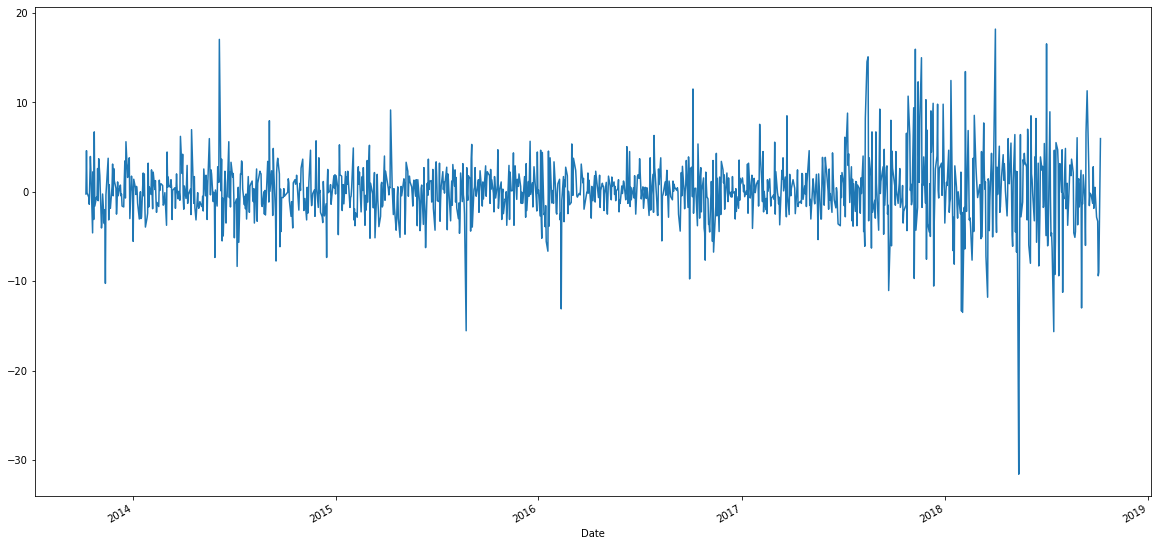

In [15]:
df['Sales First Difference'].plot()

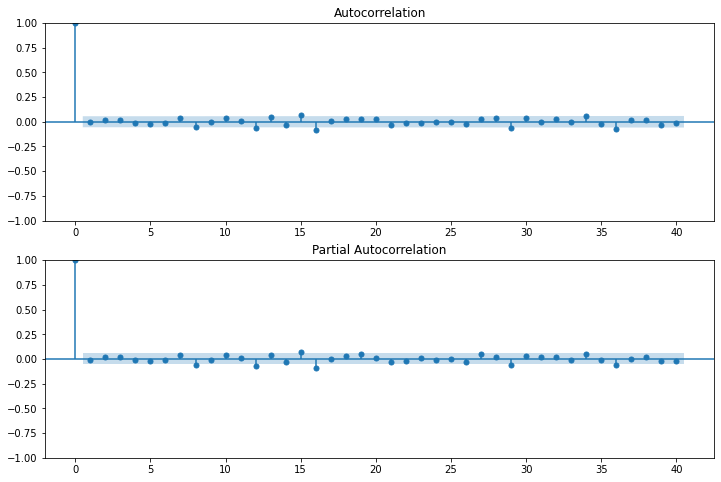

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Sales First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Sales First Difference'].dropna(),lags=40,ax=ax2)

In [17]:
df=df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1235 entries, 2013-10-08 to 2018-10-08
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Close                   1235 non-null   float64
 1   Sales First Difference  1234 non-null   float64
dtypes: float64(2)
memory usage: 28.9 KB


In [18]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df['Close'],order=(1,1,1))
model_fit=model.fit()
forecast=model_fit.predict(start=987,end=1234,dynamic=True)
ploty["ARIMA"]= forecast

In [19]:
ploty

,Close,CNN,LSTM,ARIMA
Date,,,,
2017-10-09,208.3,210.103699,199.519012,209.605321
2017-10-10,208.45,209.375504,200.692276,209.607655
2017-10-11,209.4,208.706894,200.306213,209.608679
2017-10-12,212.0,209.321762,203.178955,209.609128
2017-10-13,210.25,211.815842,205.516617,209.609325
...,...,...,...,...
2018-10-01,230.9,235.170197,223.929337,209.609478
2018-10-03,227.6,233.263107,224.845230,209.609478
2018-10-04,218.2,229.848953,219.087662,209.609478


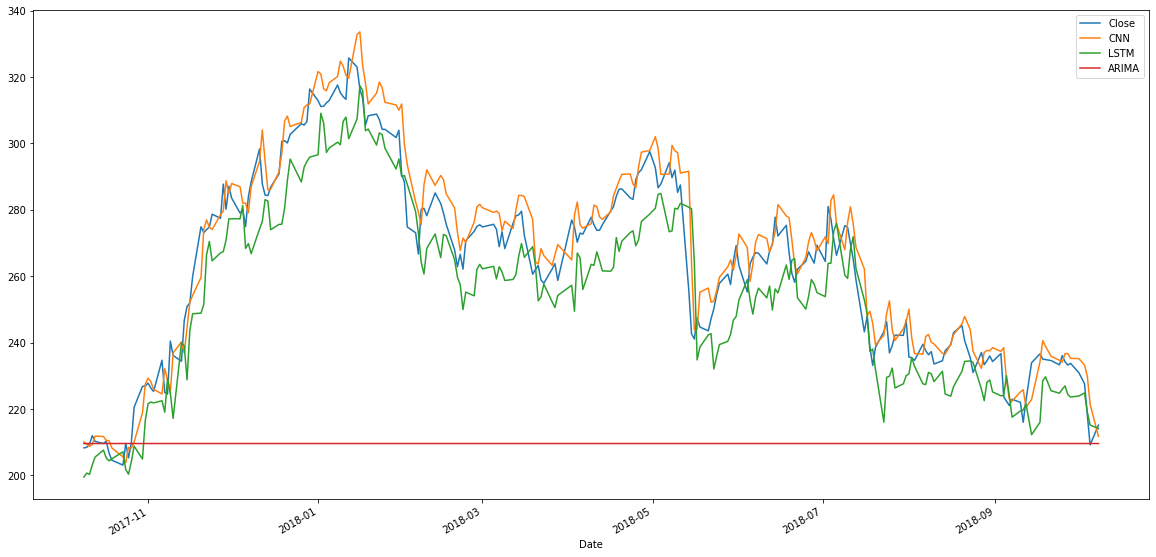

In [20]:
ploty.plot();

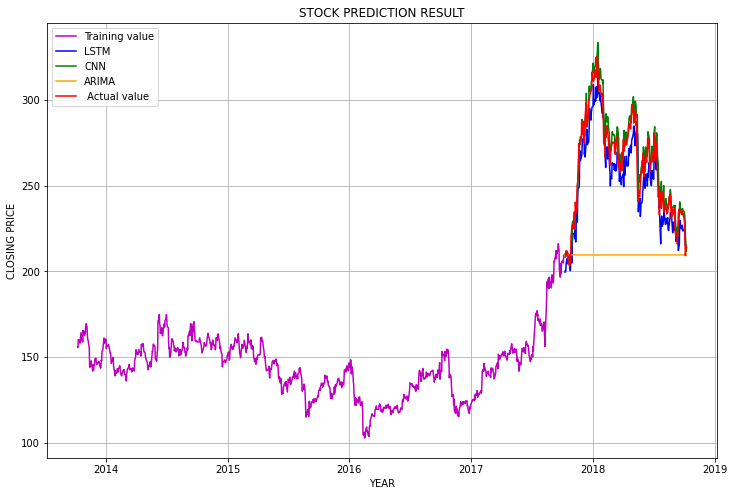

In [21]:
#for plotting
plt.figure(figsize=(12,8))
plt.plot(trainy,label ="Training value",color = "m")
plt.plot(ploty[['LSTM']],label= "LSTM",color = "b")
plt.plot(ploty[['CNN']],label= "CNN",color = "green")
plt.plot(ploty[['ARIMA']],label= "ARIMA",color = "orange" )
plt.plot(ploty[['Close']],label =" Actual value",color = "red")
plt.title("STOCK PREDICTION RESULT")
plt.grid()
plt.xlabel("YEAR")
plt.ylabel("CLOSING PRICE")
plt.legend()
plt.savefig("STOCK_PREDICTION_RESULT.png")


In [22]:
from sklearn.metrics import r2_score
print("Accuracy for ARIMA : ",r2_score(ploty["Close"],ploty["ARIMA"]))
print("Accuracy for LSTM : ",r2_score(ploty["Close"],ploty["LSTM"]))
print("Accuracy for CNN : ",r2_score(ploty["Close"],ploty["CNN"]))

Accuracy for ARIMA :  -3.4656030073894355
Accuracy for LSTM :  0.8123087284911702
Accuracy for CNN :  0.9288822850826366


### Conclusion:
CNN is giving better result than LSTM and ARIMA model